# 机组排班优化问题

2025.10.31

决策变量: 

$ w_i $ ，0-1变量，表示航班 $ i $ 是否满足资格配置

$ x_{ij}^r $ ，0-1变量，表示可以被连续执行的两趟航班 $ i $ 和 $ j $ 是否在最优解中被分配给了机组人员 $ r $

$ z_i^{rk} $ ，0-1变量，表示机组人员 $ r $ 被分配给了航班 $ i $，且担任角色 $ k $

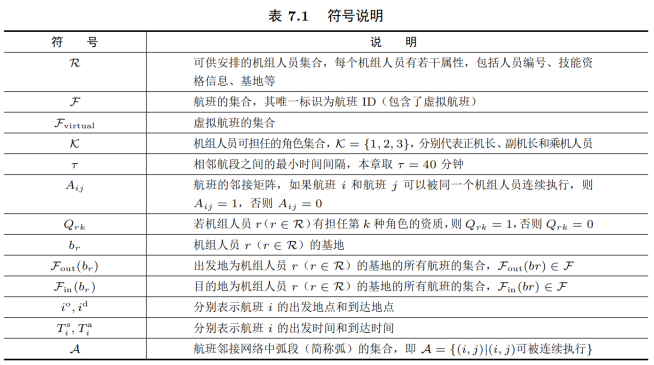

### 问题建模

$ \max \sum_{i \in \mathcal{F}} w_i \;\;\;\;\; $ 最大化满足机组配置的航班数量


$ \text{s.t.} \quad \sum_{i \in \mathcal{F}_{\text{out}}(b_r)} \sum_{j \in \mathcal{F}} x_{ij}^r \leqslant 1, \quad \forall r \in \mathcal{R} \;\;\;\;\;$ 每一个机组人员最多从其虚拟基地出发一次

$ \sum_{j \in \mathcal{F}} \sum_{i \in \mathcal{F}_{\text{in}}(b_r)} x_{ji}^r = \sum_{i \in \mathcal{F}_{\text{out}}(b_r)} \sum_{j \in \mathcal{F}} x_{ij}^r, \quad \forall r \in \mathcal{R} \;\;\;\;\;$每一个机组人员如果从基地出发，则最终必须要回到基地



$ \sum_{j \in \mathcal{F}} x_{ij}^r = \sum_{j \in \mathcal{F}} x_{ji}^r, \quad \forall r \in \mathcal{R},\ \forall i \in \mathcal{F} \setminus \mathcal{F}_{\text{virtual}} \;\;\;\;\;$保证了同一个机组人员的路径的连贯性


$\sum_{j \in \mathcal{F}} x_{ij}^r = \sum_{k \in \mathcal{K}} z_i^{rk}, \quad \forall i \in \mathcal{F},\ \forall r \in \mathcal{R}\;\;\;\;\;$保证机组人员必须且只能是机长或副机长


$z_i^{rk} \leqslant Q_{rk}, \quad \forall i \in \mathcal{F},\ \forall k \in \mathcal{K},\ \forall r \in \mathcal{R}\;\;\;\;\;$保证机组人员担任（副）机长的资质


$w_i = \sum_{r \in \mathcal{R}} z_i^{r1}, \quad \forall i \in \mathcal{F}\;\;\;\;\;$ 满足正机长（k=1）配置的航班，此处航班 i 只需要一个正机长

$w_i = \sum_{r \in \mathcal{R}} z_i^{r2}, \quad \forall i \in \mathcal{F}\;\;\;\;\;$满足副机长（k=2）配置的航班，此处航班 i 只需要一个副机长

$x_{ij}^r, z_i^{rk}, w_i \in \{0, 1\}, \quad \forall r \in \mathcal{R},\ \forall i,\ j \in \mathcal{F},\ \forall k \in \mathcal{K}$

### 代码（python）

#### 1）COPT

导入库 coptpy

In [1]:
from coptpy import *
import csv
import copy
import random

定义员工类

In [2]:
class Crew:
    def __init__(self):
        self.EmpNo = None  # 员工编号
        self.is_Captain = False  # 是否正机长
        self.is_FirstOfficer = False  # 是否副驾驶 (FirstOfficer)
        self.is_Deadhead = False  # 是否允许乘机 (Deadhead)
        self.Base = "NKX"  # 机组人员的基地机场
        self.DutyCostPerHour = None  # 每小时的执勤 (Duty) 成本
        self.ParingCostPerHour = None  # 每小时的任务环成本 (Paring Cost)

定义航班类

In [3]:
class Flight:
    def __init__(self):
        self.FltNum = None  # 航班号
        self.DptrDate = None  # 出发日期
        self.DptrTime = None  # 出发时间
        self.DptrStn = "NKX"  # 出发机场
        self.ArrvDate = None  # 到达日期
        self.ArrvTime = None  # 到达时间
        self.ArrvStn = "NKX"  # 到达机场
        self.FltTime = None  # 航班的飞行时间
        self.Comp = "C1F1"  # 资格配置 (Composition)

读取数据

In [4]:
class Data():
    def __init__(self):
        self.crew_list = []  # 机组人员列表
        self.flight_list = []  # 航班列表
        self.crew_base = []  # 机组人员基地机场列表
        self.flight_id_list = []  # 航班号的列表
        self.emp_id_list = []  # 机组人员编号列表
        self.Adj_matrix = {}  # 航班邻接矩阵
        self.Role_matrix = []

    # 读取数据
    def read_data(
            self,
            Crew_data_file=None,
            Flight_data_file=None,
            crew_select_interval=None,
            flight_select_interval=None
    ):
        """
        从数据文件中读取数据。

        :param Crew_data_file:              Crew 数据文件名
        :param Flight_data_file:             Flight 数据文件名
        :param crew_select_interval:         crew 的选择间隔。用来控制算例的规模，设置为1表示所有数据全选。
        :param flight_select_interval:       flight 的选择间隔。用来控制算例的规模，设置为1表示所有数据全选。
        :return:
        """
        # 读取 crew data
        with open(Crew_data_file, 'r') as f:
            reader1 = csv.reader(f)
            headings = next(reader1)
            cnt = 0
            for row in reader1:
                cnt += 1
                if (cnt % crew_select_interval == 0):
                    crew = Crew()
                    crew.EmpNo = row[0]
                    if row[1] == 'Y':
                        crew.is_Captain = True
                    if row[2] == 'Y':
                        crew.is_FirstOfficer = True
                    if row[3] == 'Y':
                        crew.is_Deadhead = True
                    crew.Base = row[4]
                    self.crew_base.append(crew.Base)

                    crew.DutyCostPerHour = row[5]
                    crew.ParingCostPerHour = row[6]

                    self.crew_list.append(crew)

                    self.emp_id_list.append(crew.EmpNo)

        # 读取 flight data
        with open(Flight_data_file, 'r') as f:
            reader2 = csv.reader(f)
            headings = next(reader2)
            cnt = 0
            for row in reader2:
                cnt += 1
                if (cnt % flight_select_interval == 0):
                    flight = Flight()
                    flight.FltNum = row[0] + '-' + row[1].split('/')[1]
                    flight.DptrDate = row[1]
                    flight.DptrTime = int(row[1].split("/")[1]) * 1440 + int(row[2].split(":")[0]) * 60 + int(
                        row[2].split(":")[1])
                    flight.DptrStn = row[3]
                    flight.ArrvDate = row[4]
                    flight.ArrvTime = int(row[4].split("/")[1]) * 1440 + int(row[5].split(":")[0]) * 60 + int(
                        row[5].split(":")[1])
                    flight.ArrvStn = row[6]
                    flight.FltTime = flight.ArrvTime - flight.DptrTime
                    flight.Comp = row[7]
                    self.flight_list.append(flight)

                    self.flight_id_list.append(flight.FltNum)

        # 随机筛选一定数量的航班和机组人员
        # flight_list_selected = random.sample(flight_list, flight_num)

        # 根据Base的数量生成虚拟的航班号
        self.crew_base = list(set(self.crew_base))
        for i in range(len(self.crew_base)):
            flight = Flight()
            flight.FltNum = self.crew_base[i]
            flight.DptrTime = 1e10
            flight.DptrStn = self.crew_base[i]
            flight.ArrvTime = 0
            flight.ArrvStn = self.crew_base[i]
            flight.FltTime = 0
            self.flight_list.insert(0, flight)

            # 注意，这里需要append虚拟航班id
            self.flight_id_list.append(flight.FltNum)

        print('Selected flight :', len(self.flight_list))
        print('Selected crew :', len(self.crew_list))

    # 生成航班邻接矩阵的函数
    def generate_adj_matrix(
            self,
            max_arc_num=None
    ):
        """
        参数:
        ----------
            输入: max_arc_num
        ----------
            输出：
            the shareability network of flights
            Example : {(1, 2): 1,
                       (1, 3): 1
                       .....
                       }
        """
        # 首先创建完全矩阵
        for i in range(len(self.flight_list)):
            for j in range(len(self.flight_list)):
                if self.flight_list[i].ArrvStn == self.flight_list[j].DptrStn:
                    if self.flight_list[i].ArrvTime < self.flight_list[j].DptrTime:
                        if self.flight_list[i].FltNum != self.flight_list[j].FltNum:
                            self.Adj_matrix[(self.flight_list[i].FltNum, self.flight_list[j].FltNum)] = 1

        # 然后进行筛选弧段
        arc_num = len(self.Adj_matrix)
        while (len(self.Adj_matrix) > max_arc_num):  # 筛选弧段
            self.Adj_matrix_copy = copy.deepcopy(self.Adj_matrix)
            found_diff_day_departure_flight = False
            for key in self.Adj_matrix_copy.keys():
                if (key in self.Adj_matrix.keys() and key[0] not in self.crew_base and key[1] not in self.crew_base):
                    FltNum_1 = key[0]
                    FltNum_2 = key[1]
                    Flt_1_start_day_ID = (int)(FltNum_1.split('-')[-1])
                    Flt_2_start_day_ID = (int)(FltNum_2.split('-')[-1])
                    if (abs(Flt_1_start_day_ID - Flt_2_start_day_ID) > 1):
                        found_diff_day_departure_flight = True
                        del self.Adj_matrix[key]
            if (found_diff_day_departure_flight == False):
                """ 没有找到根据出发时间可以删除的弧，那就随机删除 """
                del_arc_ID = (int)(random.random() * len(self.Adj_matrix))
                if (del_arc_ID <= len(self.Adj_matrix)):
                    key_list = list(self.Adj_matrix.keys())
                    deleted_key = key_list[del_arc_ID]
                    if (deleted_key[0] not in self.crew_base and deleted_key[1] not in self.crew_base):
                        del self.Adj_matrix[deleted_key]

        arc_num = len(self.Adj_matrix)
        print('\n\n ****  Arc Num: {}    ****\n\n'.format(arc_num))

    # 生成员工角色对应的矩阵
    def generate_role_matrix(self):
        self.Role_matrix = [[] for _ in range(len(self.crew_list))]
        for i in range(len(self.crew_list)):
            if self.crew_list[i].is_Captain == True:
                self.Role_matrix[i].append(1)
            else:
                self.Role_matrix[i].append(0)

            if self.crew_list[i].is_FirstOfficer == True:
                self.Role_matrix[i].append(1)
            else:
                self.Role_matrix[i].append(0)

            if self.crew_list[i].is_Deadhead == True:
                self.Role_matrix[i].append(1)
            else:
                self.Role_matrix[i].append(0)

    def prepare_other_data(self):
        """
        准备一些其他数据，例如：
            - Captain_id_list           正机长的list
            - FirstOfficer_id_list       副机长的list
            - No_Cap_Yes_FO_list：       不是正机长，但是是FirstOfficer的list
            - Yes_Cap_Yes_FO_list：      既是正机长，又是FirstOfficer的list

        :return:
        """
        self.Captain_id_list = []
        self.FirstOfficer_id_list = []

        self.No_Cap_Yes_FO_list = []  # 不是正机长，但是是FirstOfficer的list
        self.Yes_Cap_Yes_FO_list = []  # 既是正机长，又是是FirstOfficer的list

        for i in range(len(self.crew_list)):
            if self.crew_list[i].is_Captain == True:
                self.Captain_id_list.append(self.crew_list[i].EmpNo)
            if self.crew_list[i].is_FirstOfficer == True:
                self.FirstOfficer_id_list.append(self.crew_list[i].EmpNo)

        for i in range(len(self.crew_list)):
            if self.crew_list[i].is_Captain == False and self.crew_list[i].is_FirstOfficer == True:
                self.No_Cap_Yes_FO_list.append(self.crew_list[i].EmpNo)
            if self.crew_list[i].is_Captain == True and self.crew_list[i].is_FirstOfficer == True:
                self.Yes_Cap_Yes_FO_list.append(self.crew_list[i].EmpNo)

In [5]:
Crew_data_file = "机组排班Data A-Crew.csv"
Flight_data_file = "机组排班Data A-Flight.csv"

# 设置算例的参数
crew_select_interval = 1
flight_select_interval = 1
max_arc_num = 7000

# 读取机组人员、航班的数据
data = Data()
data.read_data(
    Crew_data_file=Crew_data_file,
    Flight_data_file=Flight_data_file,
    crew_select_interval=crew_select_interval,
    flight_select_interval=flight_select_interval
)

Selected flight : 207
Selected crew : 21


In [6]:
data.generate_adj_matrix(max_arc_num=max_arc_num)
data.Adj_matrix



 ****  Arc Num: 6448    ****




{('NKX', 'FA680-11'): 1,
 ('NKX', 'FA680-12'): 1,
 ('NKX', 'FA680-13'): 1,
 ('NKX', 'FA680-14'): 1,
 ('NKX', 'FA680-15'): 1,
 ('NKX', 'FA680-16'): 1,
 ('NKX', 'FA680-17'): 1,
 ('NKX', 'FA680-18'): 1,
 ('NKX', 'FA680-19'): 1,
 ('NKX', 'FA680-20'): 1,
 ('NKX', 'FA680-21'): 1,
 ('NKX', 'FA680-22'): 1,
 ('NKX', 'FA680-23'): 1,
 ('NKX', 'FA680-24'): 1,
 ('NKX', 'FA680-25'): 1,
 ('NKX', 'FA812-11'): 1,
 ('NKX', 'FA812-12'): 1,
 ('NKX', 'FA812-13'): 1,
 ('NKX', 'FA812-14'): 1,
 ('NKX', 'FA812-15'): 1,
 ('NKX', 'FA812-16'): 1,
 ('NKX', 'FA812-17'): 1,
 ('NKX', 'FA812-18'): 1,
 ('NKX', 'FA812-19'): 1,
 ('NKX', 'FA812-20'): 1,
 ('NKX', 'FA812-21'): 1,
 ('NKX', 'FA812-22'): 1,
 ('NKX', 'FA812-23'): 1,
 ('NKX', 'FA812-24'): 1,
 ('NKX', 'FA812-25'): 1,
 ('NKX', 'FA854-11'): 1,
 ('NKX', 'FA854-12'): 1,
 ('NKX', 'FA854-13'): 1,
 ('NKX', 'FA854-14'): 1,
 ('NKX', 'FA854-15'): 1,
 ('NKX', 'FA854-16'): 1,
 ('NKX', 'FA854-17'): 1,
 ('NKX', 'FA854-18'): 1,
 ('NKX', 'FA854-19'): 1,
 ('NKX', 'FA854-20'): 1,


In [7]:
data.generate_role_matrix()
data.Role_matrix

[[1, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 1, 1],
 [1, 0, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1],
 [0, 1, 1]]

In [8]:
data.prepare_other_data()

##### copt接口建模

模型环境构建

In [9]:
model = Envr().createModel('Airline_Crew_Problem')

Cardinal Optimizer v8.0.1. Build date Oct 22 2025
Copyright Cardinal Operations 2025. All Rights Reserved



定义变量

In [ ]:
# 示例
'''
添加一个变量到模型中,并返回创建的一个Var类对象
'''
variable_x = model.addVar(
    lb=0.0,             # 变量的下界。可选参量，默认为 0.0
    ub=COPT.INFINITY,   # 变量的上界。可选参量，默认为 COPT.INFINITY 
    obj=0.0,            # 变量的目标函数系数。可选参量，默认为 0.0
    vtype=COPT.CONTINUOUS, # 变量类型。可选参量，默认为 COPT.CONTINUOUS，另可取COPT.BINARY, COPT.INTEGER
    name="",            # 变量的名字。可选参量，默认为 "" ，由求解器内部自动生成。
    column=None         # 变量对应的列。可选参量，默认为 None。
    )

In [10]:
x = {}
z = {}
w = {}

# 定义决策变量 x:  航班 i 和航班 j 是否被机组人员 r 连续执行
for i in data.flight_id_list:
    for j in data.flight_id_list:
        if i != j:
            if (i, j) in data.Adj_matrix:
                for r in data.emp_id_list:
                    name = 'x_' + str(i) + '_' + str(j) + '_' + str(r)
                    x[i, j, r] = model.addVar(
                        lb=0, ub=1, vtype=COPT.BINARY, name=name
                    )

# 定义决策变量 z:  机组人员 r 是否以角色 k 的身份执行航班 i
for i in data.flight_id_list:
    for r in data.emp_id_list:
        for k in range(1, 4):
            name = 'z_' + str(i) + '_' + str(r) + '_' + str(k)
            z[i, r, k] = model.addVar(
                lb=0, ub=1, vtype=COPT.BINARY, name=name
            )

# 定义决策变量 w：航班 i 是否满足了最低配置要求
for i in data.flight_id_list:
    name = 'w_' + str(i)
    w[i] = model.addVar(
        lb=0, ub=1, vtype=COPT.BINARY, name=name
    )

定义目标函数

In [ ]:
# 示例
'''
构建线性表达式
'''
linear_expresion = LinExpr() # 初始化为 0
linear_expresion = LinExpr([(x, 2), (y, 3)]) # 初始化为 2*x + 3*y
linear_expresion = LinExpr([x, y], [1, 2]) # 初始化为 x + 2*y

'''
添加新的项到当前表达式中
'''
linear_expresion.addTerm(
    var=x, # 变量
    coeff=1.0 # 系数，默认为1
    )
linear_expresion.addTerms(
    vars=[x, y], 
    coeffs=[1.0, 2.0] 
    )
'''
添加一个线性约束到模型中，返回Constraint 类对象或MConstr 类对象
'''
model.addConstr(
    lhs, # 线性约束的左端项或约束构建器
    sense=None, # 线性约束的类型。可选参量，默认为 None。可取值COPY.LESS_EQUAL, COPY.GREATER_EQUAL, COPY.EQUAL, COPY.FREE, COPY.RANGE
    rhs=None, # 线性约束的右端项。可选参量，默认为 None 。可取值为常数、Var 类对象或LinExpr 类对象。
    name=""
    )

$ \max \sum_{i \in \mathcal{F}} w_i \;\;\;\;\; $ 最大化满足机组配置的航班数量


In [12]:
# 定义目标函数：最大化满足最低配置要求的航班数量
obj = LinExpr()
for i in data.flight_id_list:
    obj.addTerms(w[i], 1)
model.setObjective(obj, COPT.MAXIMIZE)

定义约束

$ \sum_{i \in \mathcal{F}_{\text{out}}(b_r)} \sum_{j \in \mathcal{F}} x_{ij}^r \leqslant 1, \quad \forall r \in \mathcal{R} \;\;\;\;\;$ 每一个机组人员最多从其虚拟基地出发一次

$ \sum_{j \in \mathcal{F}} \sum_{i \in \mathcal{F}_{\text{in}}(b_r)} x_{ji}^r = \sum_{i \in \mathcal{F}_{\text{out}}(b_r)} \sum_{j \in \mathcal{F}} x_{ij}^r, \quad \forall r \in \mathcal{R} \;\;\;\;\;$每一个机组人员如果从基地出发，则最终必须要回到基地



In [14]:
# 流平衡
for r in data.emp_id_list:
    lhs = LinExpr()
    for j in data.flight_id_list:
        if j != data.crew_list[data.emp_id_list.index(r)].Base:
            if (data.crew_list[data.emp_id_list.index(r)].Base, j) in data.Adj_matrix:
                lhs.addTerms(x[data.crew_list[data.emp_id_list.index(r)].Base, j, r], 1)
    model.addConstr(lhs <= 1, name='flow_out_' + str(r))  # 航班流出约束

    lhs2 = LinExpr()
    for i in data.flight_id_list:
        if i != data.crew_list[data.emp_id_list.index(r)].Base:
            if (i, data.crew_list[data.emp_id_list.index(r)].Base) in data.Adj_matrix:
                lhs2.addTerms(x[i, data.crew_list[data.emp_id_list.index(r)].Base, r], 1)
    model.addConstr(lhs == lhs2, name='flow_in_' + str(r))  # 航班流入约束

$ \sum_{j \in \mathcal{F}} x_{ij}^r = \sum_{j \in \mathcal{F}} x_{ji}^r, \quad \forall r \in \mathcal{R},\ \forall i \in \mathcal{F} \setminus \mathcal{F}_{\text{virtual}} \;\;\;\;\;$保证了同一个机组人员的路径的连贯性


In [15]:
# 航班流入流出平衡约束
for r in data.emp_id_list:
    for j in data.flight_id_list:
        if j != data.crew_list[data.emp_id_list.index(r)].Base:
            expr1 = LinExpr()
            expr2 = LinExpr()
            for i in data.flight_id_list:
                if (j != i):
                    if (i, j) in data.Adj_matrix:
                        expr1.addTerms(x[i, j, r], 1)
            for k in data.flight_id_list:
                if (j != k):
                    if (j, k) in data.Adj_matrix:
                        expr2.addTerms(x[j, k, r], 1)
            model.addConstr(expr1 == expr2, name='flow_conservation_' + str(j) + "_" + str(r))

$\sum_{j \in \mathcal{F}} x_{ij}^r = \sum_{k \in \mathcal{K}} z_i^{rk}, \quad \forall i \in \mathcal{F},\ \forall r \in \mathcal{R}\;\;\;\;\;$保证机组人员必须且只能是机长或副机长


In [16]:
# 决策变量 x 和决策变量 z 的联系约束：保证被选择的机组人员在一次航班中必须担任且只担任一种角色
for r in data.emp_id_list:
    for i in data.flight_id_list:
        expr1 = LinExpr()
        expr2 = LinExpr()
        for j in data.flight_id_list:
            if i != j:
                if (i, j) in data.Adj_matrix:
                    expr1.addTerms(x[i, j, r], 1)
        for k in range(1, 4):
            expr2.addTerms(z[i, r, k], 1)

        model.addConstr(
            expr1 == expr2,
            name="zxcons_" + str(i) + "_" + str(r)
        )

$z_i^{rk} \leqslant Q_{rk}, \quad \forall i \in \mathcal{F},\ \forall k \in \mathcal{K},\ \forall r \in \mathcal{R}\;\;\;\;\;$保证机组人员担任（副）机长的资质


In [17]:
# 保证机组人员担任角色的条件
for r in data.emp_id_list:
    for k in range(1, 4):
        for i in data.flight_id_list:
            model.addConstr(
                z[i, r, k] <= int(data.Role_matrix[data.emp_id_list.index(r)][k - 1]),
                name="empcons_" + str(r) + "_" + str(i) + "_" + str(k)
            )

$w_i = \sum_{r \in \mathcal{R}} z_i^{r1}, \quad \forall i \in \mathcal{F}\;\;\;\;\;$ 满足正机长（k=1）配置的航班，此处航班 i 只需要一个正机长

$w_i = \sum_{r \in \mathcal{R}} z_i^{r2}, \quad \forall i \in \mathcal{F}\;\;\;\;\;$满足副机长（k=2）配置的航班，此处航班 i 只需要一个副机长

In [18]:
# 航班是否具备资质的约束
for i in data.flight_id_list:
    expr1 = LinExpr()
    expr2 = LinExpr()
    for r in data.emp_id_list:
        expr1.addTerms(z[i, r, 1], 1)
        expr2.addTerms(z[i, r, 2], 1)

    # 约束1，判断航班是否具备机长资质
    model.addConstr(expr1 == w[i], name="Captain_cons_" + str(i))

    # 约束2，判断航班是否具备副机长资质
    model.addConstr(expr2 == w[i], name="FirstOfficer_cons_" + str(i))

模型求解

In [19]:
model.setParam('CutLevel', 0) # 生成割平面的强度
model.setParam('HeurLevel', 3) # 启发式算法的强度
model.solve()

Setting parameter 'CutLevel' to 0
Setting parameter 'HeurLevel' to 3
Model fingerprint: e08dca30

Using Cardinal Optimizer v8.0.1 on macOS (aarch64)
Hardware has 10 cores and 10 threads. Using instruction set ARMV8 (30)
Maximizing a MIP problem

The original problem has:
    22212 rows, 148656 columns and 449982 non-zero elements
    148656 binaries

Starting the MIP solver with 10 threads and 32 tasks

Presolving the problem

The presolved problem has:
    9108 rows, 145194 columns and 404985 non-zero elements
    145194 binaries

Problem info:
    Range of matrix coefficients:    [1e+00,1e+00]
    Range of rhs coefficients:       [0e+00,0e+00]
    Range of bound coefficients:     [1e+00,1e+00]
    Range of cost coefficients:      [1e+00,1e+00]
    Density of cost:                     0.1%

     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution     Gap   Time
         0         1      --       0  2.070000e+02            --     Inf  0.61s
H        0         1      --       0 

保存模型，打印结果

In [ ]:
# 可以建模型导出成 mps 文件进行查看
model.wri`te("chapter7.mps")`

# 打印结果
print("\n\n-----optimal value-----")
print(model.ObjVal)

Writing problem to /Users/pkr/Desktop/2021-F-filght/flight/chapter7.mps


-----optimal value-----
207.0


#### 2）GUROBI

代码与COPT的基本一致，除了 

1️⃣ 常数。COPT.BINARY, GRB.BINARY

2️⃣ 变量与对应系数的位置。COPT：addTerms(w[i], 1)；GUROBI：addTerms(1, w[i])

3️⃣ 模型的定义与求解。

COPT：model = Envr().createModel('Airline_Crew_Problem') 加 model.solve()

GUROBI：model = Model('Airline_Crew_Problem') 加 model.optimize()


In [22]:
from gurobipy import *
import csv
import copy
import random

# 设置输入参数

# 定义员工类
class Crew:

    def __init__(self):
        self.EmpNo = None                   # 员工编号
        self.is_Captain = False             # 是否正机长
        self.is_FirstOfficer = False        # 是否副驾驶 (FirstOfficer)
        self.is_Deadhead = False            # 是否允许乘机 (Deadhead)
        self.Base = "NKX"                   # 机组人员的基地机场
        self.DutyCostPerHour = None         # 每小时的执勤 (Duty) 成本
        self.ParingCostPerHour = None       # 每小时的任务环成本 (Paring Cost)


# 定义航班类
class Flight:

    def __init__(self):
        self.FltNum = None              # 航班号
        self.DptrDate = None            # 出发日期
        self.DptrTime = None            # 出发时间
        self.DptrStn = "NKX"            # 出发机场
        self.ArrvDate = None            # 到达日期
        self.ArrvTime = None            # 到达时间
        self.ArrvStn = "NKX"            # 到达机场
        self.FltTime = None             # 航班的飞行时间
        self.Comp = "C1F1"              # 资格配置 (Composition)


class Data():

    def __init__(self):
        self.crew_list = []                 # 机组人员列表 
        self.flight_list = []               # 航班列表 
        self.crew_base = []                 # 机组人员基地机场列表 
        self.flight_id_list = []            # 航班号的列表
        self.emp_id_list = []               # 机组人员编号列表
        self.Adj_matrix = {}                # 航班邻接矩阵
        self.Role_matrix = []


    # 读取数据
    def read_data(
            self,
            Crew_data_file=None,
            Flight_data_file=None,
            crew_select_interval=None,
            flight_select_interval=None
    ):
        """
        从数据文件中读取数据。

        :param Crew_data_file:              Crew 数据文件名
        :param Flight_data_file:             Flight 数据文件名
        :param crew_select_interval:         crew 的选择间隔。用来控制算例的规模，设置为1表示所有数据全选。
        :param flight_select_interval:       flight 的选择间隔。用来控制算例的规模，设置为1表示所有数据全选。
        :return:
        """

        # 读取 crew data
        with open(Crew_data_file, 'r') as f:
            reader1 = csv.reader(f)
            headings = next(reader1)
            cnt = 0
            for row in reader1:
                cnt += 1
                if (cnt % crew_select_interval == 0):
                    crew = Crew()
                    crew.EmpNo = row[0]
                    if row[1] == 'Y':
                        crew.is_Captain = True
                    if row[2] == 'Y':
                        crew.is_FirstOfficer = True
                    if row[3] == 'Y':
                        crew.is_Deadhead = True
                    crew.Base = row[4]
                    self.crew_base.append(crew.Base)

                    crew.DutyCostPerHour = row[5]
                    crew.ParingCostPerHour = row[6]

                    self.crew_list.append(crew)

                    self.emp_id_list.append(crew.EmpNo)

        # 读取 flight data
        with open(Flight_data_file, 'r') as f:
            reader2 = csv.reader(f)
            headings = next(reader2)
            cnt = 0
            for row in reader2:
                cnt += 1
                if (cnt % flight_select_interval == 0):
                    flight = Flight()
                    flight.FltNum = row[0] + '-' + row[1].split('/')[1]
                    flight.DptrDate = row[1]
                    flight.DptrTime = int(row[1].split("/")[1]) * 1440 + int(row[2].split(":")[0]) * 60 + int(
                        row[2].split(":")[1])
                    flight.DptrStn = row[3]
                    flight.ArrvDate = row[4]
                    flight.ArrvTime = int(row[4].split("/")[1]) * 1440 + int(row[5].split(":")[0]) * 60 + int(
                        row[5].split(":")[1])
                    flight.ArrvStn = row[6]
                    flight.FltTime = flight.ArrvTime - flight.DptrTime
                    flight.Comp = row[7]
                    self.flight_list.append(flight)

                    self.flight_id_list.append(flight.FltNum)

        # 随机筛选一定数量的航班和机组人员
        # flight_list_selected = random.sample(flight_list, flight_num)

        # 根据Base的数量生成虚拟的航班号
        self.crew_base = list(set(self.crew_base))
        for i in range(len(self.crew_base)):
            flight = Flight()
            flight.FltNum = self.crew_base[i]
            flight.DptrTime = 1e10
            flight.DptrStn = self.crew_base[i]
            flight.ArrvTime = 0
            flight.ArrvStn = self.crew_base[i]
            flight.FltTime = 0
            self.flight_list.insert(0, flight)

            # 注意，这里需要append虚拟航班id
            self.flight_id_list.append(flight.FltNum)

        print('Selected flight :', len(self.flight_list))
        print('Selected crew :', len(self.crew_list))


    # 生成航班邻接矩阵的函数
    def generate_adj_matrix(
            self,
            max_arc_num=None
    ):
        """
        参数:
        ----------
            输入: max_arc_num
        ----------
            输出：
            the shareability network of flights
            Example : {(1, 2): 1,
                       (1, 3): 1
                       .....
                       }
        """

        # 首先创建完全矩阵
        for i in range(len(self.flight_list)):
            for j in range(len(self.flight_list)):
                if self.flight_list[i].ArrvStn == self.flight_list[j].DptrStn:
                    if self.flight_list[i].ArrvTime < self.flight_list[j].DptrTime:
                        if self.flight_list[i].FltNum != self.flight_list[j].FltNum:
                            self.Adj_matrix[(self.flight_list[i].FltNum, self.flight_list[j].FltNum)] = 1

        # 然后进行筛选弧段
        arc_num = len(self.Adj_matrix)
        while (len(self.Adj_matrix) > max_arc_num):  # 筛选弧段
            self.Adj_matrix_copy = copy.deepcopy(self.Adj_matrix)
            found_diff_day_departure_flight = False
            for key in self.Adj_matrix_copy.keys():
                if (key in self.Adj_matrix.keys() and key[0] not in self.crew_base and key[1] not in self.crew_base):
                    FltNum_1 = key[0]
                    FltNum_2 = key[1]
                    Flt_1_start_day_ID = (int)(FltNum_1.split('-')[-1])
                    Flt_2_start_day_ID = (int)(FltNum_2.split('-')[-1])
                    if (abs(Flt_1_start_day_ID - Flt_2_start_day_ID) > 1):
                        found_diff_day_departure_flight = True
                        del self.Adj_matrix[key]
            if (found_diff_day_departure_flight == False):
                """ 没有找到根据出发时间可以删除的弧，那就随机删除 """
                del_arc_ID = (int)(random.random() * len(self.Adj_matrix))
                if (del_arc_ID <= len(self.Adj_matrix)):
                    key_list = list(self.Adj_matrix.keys())
                    deleted_key = key_list[del_arc_ID]
                    if (deleted_key[0] not in self.crew_base and deleted_key[1] not in self.crew_base):
                        del self.Adj_matrix[deleted_key]

        arc_num = len(self.Adj_matrix)
        print('\n\n ****  Arc Num: {}    ****\n\n'.format(arc_num))


    # 生成员工角色对应的矩阵
    def generate_role_matrix(self):
        self.Role_matrix = [[] for _ in range(len(self.crew_list))]
        for i in range(len(self.crew_list)):
            if self.crew_list[i].is_Captain == True:
                self.Role_matrix[i].append(1)
            else:
                self.Role_matrix[i].append(0)

            if self.crew_list[i].is_FirstOfficer == True:
                self.Role_matrix[i].append(1)
            else:
                self.Role_matrix[i].append(0)

            if self.crew_list[i].is_Deadhead == True:
                self.Role_matrix[i].append(1)
            else:
                self.Role_matrix[i].append(0)


    def prepare_other_data(self):
        """

        准备一些其他数据，例如：
            - Captain_id_list           正机长的list 
            - FirstOfficer_id_list       副机长的list 
            - No_Cap_Yes_FO_list：       不是正机长，但是是FirstOfficer的list
            - Yes_Cap_Yes_FO_list：      既是正机长，又是FirstOfficer的list
        
        :return:
        """

        self.Captain_id_list = []
        self.FirstOfficer_id_list = []

        self.No_Cap_Yes_FO_list = []        # 不是正机长，但是是FirstOfficer的list
        self.Yes_Cap_Yes_FO_list = []       # 既是正机长，又是是FirstOfficer的list
        
        for i in range(len(self.crew_list)):
            if self.crew_list[i].is_Captain == True:
                self.Captain_id_list.append(self.crew_list[i].EmpNo)
            if self.crew_list[i].is_FirstOfficer == True:
                self.FirstOfficer_id_list.append(self.crew_list[i].EmpNo)

        for i in range(len(self.crew_list)):
            if self.crew_list[i].is_Captain == False and self.crew_list[i].is_FirstOfficer == True:
                self.No_Cap_Yes_FO_list.append(self.crew_list[i].EmpNo)
            if self.crew_list[i].is_Captain == True and self.crew_list[i].is_FirstOfficer == True:
                self.Yes_Cap_Yes_FO_list.append(self.crew_list[i].EmpNo)


def build_and_solve_airline_crew_scheduling_model(
        data=None
):
    # 校验数据
    if data is None:
        raise ValueError("请先初始化算例数据！")

    # 开始建立模型
    model = Model('Airline_Crew_Problem')
    x = {}
    z = {}
    w = {}

    # 定义决策变量 x:  航班 i 和航班 j 是否被机组人员 r 连续执行
    for i in data.flight_id_list:
        for j in data.flight_id_list:
            if i != j:
                if (i, j) in data.Adj_matrix:
                    for r in data.emp_id_list:
                        name = 'x_' + str(i) + '_' + str(j) + '_' + str(r)
                        x[i, j, r] = model.addVar(
                            lb=0, ub=1, vtype=GRB.BINARY, name=name
                        )

    # 定义决策变量 z:  机组人员 r 是否以角色 k 的身份执行航班 i
    for i in data.flight_id_list:
        for r in data.emp_id_list:
            for k in range(1, 4):
                name = 'z_' + str(i) + '_' + str(r) + '_' + str(k)
                z[i, r, k] = model.addVar(
                    lb=0, ub=1, vtype=GRB.BINARY, name=name
                )

    # 定义决策变量 w：航班 i 是否满足了最低配置要求
    for i in data.flight_id_list:
        name = 'w_' + str(i)
        w[i] = model.addVar(
            lb=0, ub=1, vtype=GRB.BINARY, name=name
        )

    # 定义目标函数：最大化满足最低配置要求的航班数量
    obj = LinExpr()
    for i in data.flight_id_list:
        obj.addTerms(1, w[i])
    model.setObjective(obj, GRB.MAXIMIZE)

    # 约束 7.7-7.8 流平衡
    for r in data.emp_id_list:
        lhs = LinExpr()
        for j in data.flight_id_list:
            if j != data.crew_list[data.emp_id_list.index(r)].Base:
                if (data.crew_list[data.emp_id_list.index(r)].Base, j) in data.Adj_matrix:
                    lhs.addTerms(1, x[data.crew_list[data.emp_id_list.index(r)].Base, j, r])
        model.addConstr(lhs <= 1, name='flow_out_' + str(r))  # 航班流出约束 7.7

        lhs2 = LinExpr()
        for i in data.flight_id_list:
            if i != data.crew_list[data.emp_id_list.index(r)].Base:
                if (i, data.crew_list[data.emp_id_list.index(r)].Base) in data.Adj_matrix:
                    lhs2.addTerms(1, x[i, data.crew_list[data.emp_id_list.index(r)].Base, r])
        model.addConstr(lhs == lhs2, name='flow_in_' + str(r))  # 航班流入约束 7.8

    # 航班流入流出平衡约束 7.9
    for r in data.emp_id_list:
        for j in data.flight_id_list:
            if j != data.crew_list[data.emp_id_list.index(r)].Base:
                expr1 = LinExpr()
                expr2 = LinExpr()
                for i in data.flight_id_list:
                    if (j != i):
                        if (i, j) in data.Adj_matrix:
                            expr1.addTerms(1, x[i, j, r])
                for k in data.flight_id_list:
                    if (j != k):
                        if (j, k) in data.Adj_matrix:
                            expr2.addTerms(1, x[j, k, r])
                model.addConstr(expr1 == expr2, name='flow_conservation_' + str(j) + "_" + str(r))

    # 约束 7.10：决策变量 x 和决策变量 z 的联系约束：保证被选择的机组人员在一次航班中必须担任且只担任一种角
    for r in data.emp_id_list:
        for i in data.flight_id_list:
            expr1 = LinExpr()
            expr2 = LinExpr()
            for j in data.flight_id_list:
                if i != j:
                    if (i, j) in data.Adj_matrix:
                        expr1.addTerms(1, x[i, j, r])
            for k in range(1, 4):
                expr2.addTerms(1, z[i, r, k])

            model.addConstr(
                expr1 == expr2,
                name="zxcons_" + str(i) + "_" + str(r)
            )

    # 约束7.11：保证机组人员担任角色的条件
    for r in data.emp_id_list:
        for k in range(1, 4):
            for i in data.flight_id_list:
                model.addConstr(
                    z[i, r, k] <= int(data.Role_matrix[data.emp_id_list.index(r)][k - 1]),
                    name="empcons_" + str(r) + "_" + str(i) + "_" + str(k)
                )

    # 约束7.12-7.13: 航班是否具备资质的约束
    for i in data.flight_id_list:
        expr1 = LinExpr()
        expr2 = LinExpr()
        for r in data.emp_id_list:
            expr1.addTerms(1, z[i, r, 1])
            expr2.addTerms(1, z[i, r, 2])

        # 约束7.12: 判断航班是否具备机长资质
        model.addConstr(expr1 == w[i], name="Captain_cons_" + str(i))

        # 约束7.13: 判断航班是否具备副机长资质 
        model.addConstr(expr2 == w[i], name="FirstOfficer_cons_" + str(i))

    # 求解模型
    # model.setParam('Cuts', 0)
    model.optimize()

    # 打印求解结果
    print("\n\n-----optimal value-----")
    print(model.ObjVal)


if __name__ == '__main__':

    # 给定数据文件名
    Crew_data_file = "机组排班Data A-Crew.csv"
    Flight_data_file = "机组排班Data A-Flight.csv"

    # 设置算例的参数
    crew_select_interval = 1
    flight_select_interval = 1
    max_arc_num = 7000

    # 读取机组人员、航班的数据
    data = Data()
    data.read_data(
        Crew_data_file=Crew_data_file,
        Flight_data_file=Flight_data_file,
        crew_select_interval=crew_select_interval,
        flight_select_interval=flight_select_interval
    )
    
    # 调用函数生成航班邻接矩阵等参数
    data.generate_adj_matrix(max_arc_num=max_arc_num)

    # 生成角色矩阵
    data.generate_role_matrix()

    # 准备一些额外的数据
    data.prepare_other_data()
    
    # 建模求解
    build_and_solve_airline_crew_scheduling_model(data=data)

Selected flight : 207
Selected crew : 21


 ****  Arc Num: 6448    ****


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 25.0.0 25A8364)

CPU model: Apple M5
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 22170 rows, 148656 columns and 443535 nonzeros
Model fingerprint: 0x079b2eab
Variable types: 0 continuous, 148656 integer (148656 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 13098 rows and 3420 columns
Presolve time: 0.24s
Presolved: 9072 rows, 145236 columns, 405075 nonzeros
Variable types: 0 continuous, 145236 integer (145236 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.05s

Solved with dual simplex

Use crossover to convert LP symmetric solutio